In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download sripaadsrinivasan/audio-mnist

Dataset URL: https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist
License(s): CC0-1.0
 98% 934M/948M [00:12<00:00, 76.2MB/s]
100% 948M/948M [00:12<00:00, 78.8MB/s]


In [ ]:
! unzip /content/audio-mnist.zip

In [5]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm for progress indication

# Path to the dataset
dataset_path = '/content/data'

# Load dataset
def load_audio_files(dataset_path):
    X = []
    y = []
    for folder in tqdm(os.listdir(dataset_path), desc='Loading dataset'):  # Add tqdm here
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.isdir(folder_path):  # Check if it's a directory
            continue
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path, sr=16000)
                X.append(audio)
                label = int(file.split('_')[0])
                y.append(label)
    return X, y

# Load the dataset
X, y = load_audio_files(dataset_path)

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the sizes of the splits
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")



Loading dataset: 100%|██████████| 61/61 [00:51<00:00,  1.18it/s]

Training set size: 24000
Test set size: 6000


In [7]:
def extract_mfcc_features(audio, sr, n_mfcc=12, frame_length=0.025, hop_length=0.01):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=int(frame_length*sr), n_mels=24)
    mean = np.mean(mfcc, axis=1)
    return mean

# Extract MFCC features for the dataset
X_train_mfcc = [extract_mfcc_features(x, 16000) for x in X_train]
X_test_mfcc = [extract_mfcc_features(x, 16000) for x in X_test]




# Convert to numpy arrays
X_train_mfcc = np.array(X_train_mfcc)
X_test_mfcc = np.array(X_test_mfcc)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("MFCC feature extraction complete.")


MFCC feature extraction complete.


In [8]:
X_train_mfcc.shape

(24000, 12)

In [18]:
import numpy as np

class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # وزن‌ها
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.hidden_size)
        self.W3 = np.random.randn(self.hidden_size, self.output_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.hidden_size))
        self.b3 = np.zeros((1, self.output_size))

    def bipolar_sigmoid(self, x):
        return 2 / (1 + np.exp(-x)) - 1

    def bipolar_sigmoid_derivative(self, x):
        return 0.5 * (1 + x) * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def forward(self, x):
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.bipolar_sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.bipolar_sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.bipolar_sigmoid(self.z3)
        return self.a3

    def backward(self, x, y, output):
        m = y.shape[0]
        delta3 = output - y
        dW3 = np.dot(self.a2.T, delta3) / m
        db3 = np.sum(delta3, axis=0, keepdims=True) / m

        delta2 = np.dot(delta3, self.W3.T) * self.bipolar_sigmoid_derivative(self.a2)
        dW2 = np.dot(self.a1.T, delta2) / m
        db2 = np.sum(delta2, axis=0, keepdims=True) / m

        delta1 = np.dot(delta2, self.W2.T) * self.bipolar_sigmoid_derivative(self.a1)
        dW1 = np.dot(x.T, delta1) / m
        db1 = np.sum(delta1, axis=0, keepdims=True) / m

        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2
        self.W3 -= self.learning_rate * dW3
        self.b1 -= self.learning_rate * db1
        self.b2 -= self.learning_rate * db2
        self.b3 -= self.learning_rate * db3

    def train(self, X, y, epochs=30):
        mse_errors = []
        accuracies = []

        for epoch in range(epochs):
            total_error = 0
            correct_predictions = 0
            class_correct = np.zeros(self.output_size)
            class_total = np.zeros(self.output_size)

            for i in range(len(X)):
                X_sample = X[i].reshape(1, -1)
                y_sample = y[i].reshape(1, -1)

                output = self.forward(X_sample)

                self.backward(X_sample, y_sample, output)

                # Calculate accuracy
                predicted_class = np.argmax(self.softmax(output))
                true_class = np.argmax(y_sample)
                if predicted_class == true_class:
                    correct_predictions += 1
                    class_correct[true_class] += 1
                class_total[true_class] += 1

                total_error += self.mse(y_sample, output)

            avg_error = total_error / len(X)
            accuracy = correct_predictions / len(X)
            mse_errors.append(avg_error)
            accuracies.append(accuracy)
            print(f"Epoch {epoch+1}/{epochs}, Avg Error: {avg_error:.6f}, Accuracy: {accuracy:.6f}")

            # Print accuracy for each class
            for i in range(self.output_size):
                class_accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                print(f"Class {i} Accuracy: {class_accuracy:.6f}")

        return mse_errors, accuracies

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(self.softmax(output), axis=1)

# Define the size of the input, hidden and output layers
input_size = X_train_mfcc.shape[1]
hidden_size = (input_size + 10) // 2
output_size = 10

# Initialize the MLP
mlp = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=0.001)

# one-hot encoding
def to_one_hot(y, num_classes):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

y_train_one_hot = to_one_hot(y_train, output_size)

# Train the MLP
mse_errors, accuracies = mlp.train(X_train_mfcc, y_train_one_hot, epochs=5)




<ipython-input-18-029632d436d7>:19: RuntimeWarning: overflow encountered in exp
  return 2 / (1 + np.exp(-x)) - 1


Epoch 1/5, Avg Error: 0.094799, Accuracy: 0.098333
Class 0 Accuracy: 0.098693
Class 1 Accuracy: 0.090235
Class 2 Accuracy: 0.052919
Class 3 Accuracy: 0.144477
Class 4 Accuracy: 0.068737
Class 5 Accuracy: 0.118869
Class 6 Accuracy: 0.130325
Class 7 Accuracy: 0.025353
Class 8 Accuracy: 0.110790
Class 9 Accuracy: 0.143211
Epoch 2/5, Avg Error: 0.090456, Accuracy: 0.097042
Class 0 Accuracy: 0.101645
Class 1 Accuracy: 0.100536
Class 2 Accuracy: 0.058379
Class 3 Accuracy: 0.145737
Class 4 Accuracy: 0.073292
Class 5 Accuracy: 0.071904
Class 6 Accuracy: 0.130747
Class 7 Accuracy: 0.026600
Class 8 Accuracy: 0.114924
Class 9 Accuracy: 0.146925
Epoch 3/5, Avg Error: 0.090447, Accuracy: 0.096500
Class 0 Accuracy: 0.100801
Class 1 Accuracy: 0.100124
Class 2 Accuracy: 0.059219
Class 3 Accuracy: 0.141537
Class 4 Accuracy: 0.073292
Class 5 Accuracy: 0.071072
Class 6 Accuracy: 0.129059
Class 7 Accuracy: 0.027847
Class 8 Accuracy: 0.114924
Class 9 Accuracy: 0.147338
Epoch 4/5, Avg Error: 0.090439, Accur

In [20]:
import numpy as np

class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Xavier initialization for weights
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(1. / self.input_size)
        self.W2 = np.random.randn(self.hidden_size, self.hidden_size) * np.sqrt(1. / self.hidden_size)
        self.W3 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(1. / self.hidden_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.hidden_size))
        self.b3 = np.zeros((1, self.output_size))

    def bipolar_sigmoid(self, x):
        return 2 / (1 + np.exp(-x)) - 1

    def bipolar_sigmoid_derivative(self, x):
        return 0.5 * (1 + x) * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def forward(self, x):
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.bipolar_sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.bipolar_sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.bipolar_sigmoid(self.z3)
        return self.a3

    def backward(self, x, y, output):
        m = y.shape[0]
        delta3 = output - y
        dW3 = np.dot(self.a2.T, delta3) / m
        db3 = np.sum(delta3, axis=0, keepdims=True) / m

        delta2 = np.dot(delta3, self.W3.T) * self.bipolar_sigmoid_derivative(self.a2)
        dW2 = np.dot(self.a1.T, delta2) / m
        db2 = np.sum(delta2, axis=0, keepdims=True) / m

        delta1 = np.dot(delta2, self.W2.T) * self.bipolar_sigmoid_derivative(self.a1)
        dW1 = np.dot(x.T, delta1) / m
        db1 = np.sum(delta1, axis=0, keepdims=True) / m

        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2
        self.W3 -= self.learning_rate * dW3
        self.b1 -= self.learning_rate * db1
        self.b2 -= self.learning_rate * db2
        self.b3 -= self.learning_rate * db3

    def train(self, X, y, epochs=30):
        mse_errors = []
        accuracies = []

        for epoch in range(epochs):
            total_error = 0
            correct_predictions = 0
            class_correct = np.zeros(self.output_size)
            class_total = np.zeros(self.output_size)

            for i in range(len(X)):
                X_sample = X[i].reshape(1, -1)
                y_sample = y[i].reshape(1, -1)

                output = self.forward(X_sample)

                self.backward(X_sample, y_sample, output)

                # Calculate accuracy
                predicted_class = np.argmax(self.softmax(output))
                true_class = np.argmax(y_sample)
                if predicted_class == true_class:
                    correct_predictions += 1
                    class_correct[true_class] += 1
                class_total[true_class] += 1

                total_error += self.mse(y_sample, output)

            avg_error = total_error / len(X)
            accuracy = correct_predictions / len(X)
            mse_errors.append(avg_error)
            accuracies.append(accuracy)
            print(f"Epoch {epoch+1}/{epochs}, Avg Error: {avg_error:.6f}, Accuracy: {accuracy:.6f}")

            # Print accuracy for each class
            for i in range(self.output_size):
                class_accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                print(f"Class {i} Accuracy: {class_accuracy:.6f}")

        return mse_errors, accuracies

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(self.softmax(output), axis=1)

# Ensure the data is normalized
X_train_mfcc = (X_train_mfcc - np.mean(X_train_mfcc, axis=0)) / np.std(X_train_mfcc, axis=0)
X_test_mfcc = (X_test_mfcc - np.mean(X_test_mfcc, axis=0)) / np.std(X_test_mfcc, axis=0)

# Define the size of the input, hidden and output layers
input_size = X_train_mfcc.shape[1]
hidden_size = (input_size + 10) // 2
output_size = 10

# Initialize the MLP
mlp = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=0.001)

# one-hot encoding
def to_one_hot(y, num_classes):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

y_train_one_hot = to_one_hot(y_train, output_size)

# Train the MLP
mse_errors, accuracies = mlp.train(X_train_mfcc, y_train_one_hot, epochs=5)




Epoch 1/5, Avg Error: 0.076570, Accuracy: 0.437167
Class 0 Accuracy: 0.090679
Class 1 Accuracy: 0.214256
Class 2 Accuracy: 0.344393
Class 3 Accuracy: 0.434271
Class 4 Accuracy: 0.778468
Class 5 Accuracy: 0.539069
Class 6 Accuracy: 0.878954
Class 7 Accuracy: 0.293017
Class 8 Accuracy: 0.775940
Class 9 Accuracy: 0.024763
Epoch 2/5, Avg Error: 0.066970, Accuracy: 0.578708
Class 0 Accuracy: 0.109237
Class 1 Accuracy: 0.459415
Class 2 Accuracy: 0.528769
Class 3 Accuracy: 0.648047
Class 4 Accuracy: 0.921325
Class 5 Accuracy: 0.881546
Class 6 Accuracy: 0.980177
Class 7 Accuracy: 0.185786
Class 8 Accuracy: 0.875982
Class 9 Accuracy: 0.196863
Epoch 3/5, Avg Error: 0.064074, Accuracy: 0.640875
Class 0 Accuracy: 0.239561
Class 1 Accuracy: 0.479192
Class 2 Accuracy: 0.528349
Class 3 Accuracy: 0.657287
Class 4 Accuracy: 0.934576
Class 5 Accuracy: 0.904821
Class 6 Accuracy: 0.979755
Class 7 Accuracy: 0.333749
Class 8 Accuracy: 0.907400
Class 9 Accuracy: 0.442427
Epoch 4/5, Avg Error: 0.062667, Accur

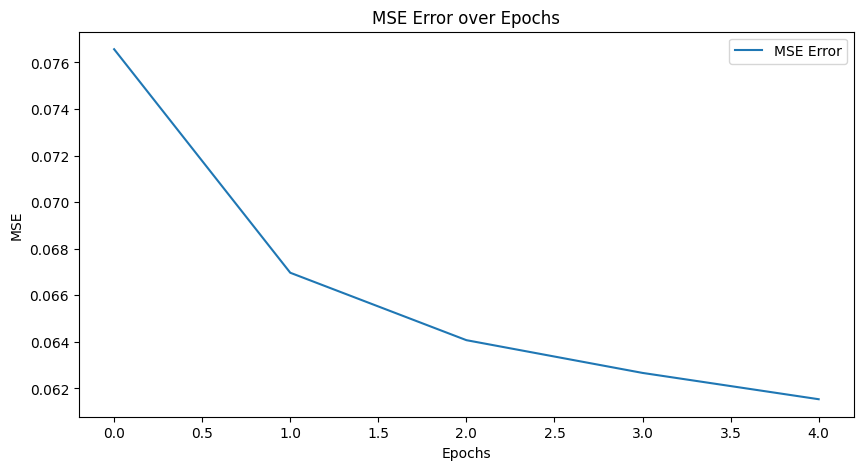

In [21]:
import matplotlib.pyplot as plt
# Plot MSE errors
plt.figure(figsize=(10, 5))
plt.plot(mse_errors, label='MSE Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE Error over Epochs')
plt.legend()
plt.show()






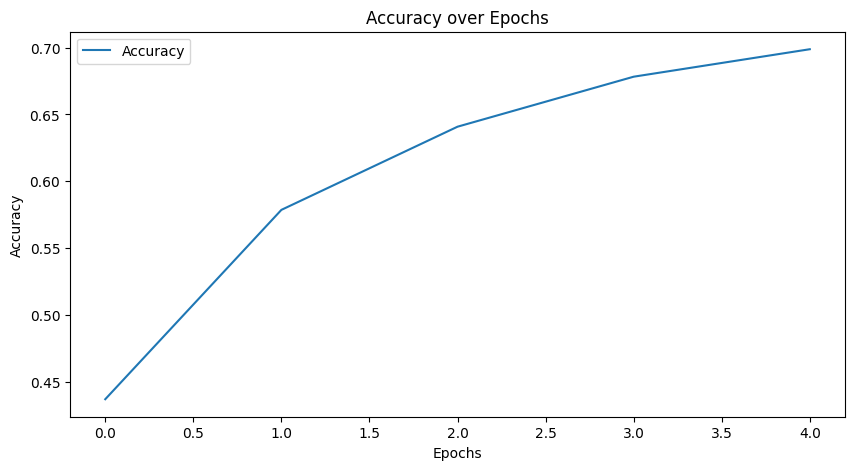

In [22]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [23]:
# Predict on test data
y_pred = mlp.predict(X_test_mfcc)

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate accuracy for each class on test data
class_correct = np.zeros(output_size)
class_total = np.zeros(output_size)

for i in range(len(y_test)):
    true_class = y_test[i]
    predicted_class = y_pred[i]
    if true_class == predicted_class:
        class_correct[true_class] += 1
    class_total[true_class] += 1

for i in range(output_size):
    class_accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Test Class {i} Accuracy: {class_accuracy * 100:.2f}%")

Test Accuracy: 69.98%
Test Class 0 Accuracy: 52.78%
Test Class 1 Accuracy: 48.34%
Test Class 2 Accuracy: 42.00%
Test Class 3 Accuracy: 67.69%
Test Class 4 Accuracy: 93.50%
Test Class 5 Accuracy: 89.06%
Test Class 6 Accuracy: 97.93%
Test Class 7 Accuracy: 59.43%
Test Class 8 Accuracy: 91.39%
Test Class 9 Accuracy: 58.06%
